In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [77]:
#Read in the data collected from the data collection notebook
df_wsb = pd.read_csv('./csv_files/wsb_data.csv')
df_wsb_test = pd.read_csv('./csv_files/wsb_data_test.csv')
df_sm = pd.read_csv('./csv_files/sm_data.csv')
df_sm_test = pd.read_csv('./csv_files/sm_data_test.csv')

In [78]:
#Combine the datasets into one dataframe for test and train
df = pd.concat([df_wsb,df_sm], axis = 0)
df_test = pd.concat([df_wsb_test,df_sm_test],axis = 0)

In [79]:
#Drop unnamed index column
df.drop(columns='Unnamed: 0',inplace= True)
df_test.drop(columns='Unnamed: 0',inplace= True)

In [80]:
#Check the train dataset for null values
df.isnull().sum()

subreddit         0
selftext       4671
title             0
created_utc       0
dtype: int64

In [81]:
#Check the test dataset for null values
df_test.isnull().sum()

subreddit        0
selftext       114
title            0
created_utc      0
dtype: int64

In [82]:
#Replace the null values in the selftext column with a blank space, theres no way for us to get that data and we dont want to drop it all
df.fillna('',inplace = True)
df_test.fillna('',inplace = True)

In [83]:
df['subreddit'].value_counts()

wallstreetbets    4000
StockMarket       4000
Name: subreddit, dtype: int64

In [84]:
#Binarize the subreddit classes
df['subreddit'] = df['subreddit'].map({'wallstreetbets': 1, 'StockMarket': 0 })
df_test['subreddit'] = df_test['subreddit'].map({'wallstreetbets': 1, 'StockMarket': 0 })

In [85]:
#Checked if the binarize worked
df['subreddit'].value_counts()

1    4000
0    4000
Name: subreddit, dtype: int64

In [86]:
#Create X and y 
X= df['title']
y = df['subreddit']
test_X= df_test['title']
test_y = df_test['subreddit']

In [12]:
#Import Models being used from sklearn and xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [13]:
#Train test split our X and Y
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state = 42)

# Modelling 
For our modelling we're going to be trying five different types of models, XGboost, Logistic Regression, Bagging, Random Forest And KNN. We chose to do five models because so we can have a better chance of getting a higher classification accuracy, and it also helps see what the average of the accuracy would be.

# Xgboost Model, default parameters

For our first model we're going to be using the default parameters within the xgboost to get a baseline of the score using xgboost

In [14]:
#Transform the text with countvectorizer and then put that into an xgb classifier
pipe_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])

In [15]:
#Fit Xgb model
pipe_xgb.fit(X_train,y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_t

In [16]:
#Model scores
print(pipe_xgb.score(X_train,y_train))
pipe_xgb.score(X_test,y_test)

0.8261666666666667


0.736

Just looking at the scores we can see that our model is overfit using the default parameters but it predicts the right subreddit 73% of the time, 23% higher than the baseline. This is pretty decent of an increase but lets see if we can either get a less overfit model or higher test accuracy utilizing gridsearch with xgb.

# XgBoost Model with hyperparameter tuning

In [17]:
#Refit the Xgboost model with more optimized hyperparameters
pipe_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])
pipe_params = {
    'xgb__learning_rate':[0.3,1.0],
    'xgb__max_depth':[3,7],
    'xgb__base_score':[0.3,0.7],
    'cvec__max_features': [2000,8000],
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)],
    'cvec__min_df':[1,2],
    'cvec__max_df':[0.5,0.9]
}

In [18]:
#GridSearch
gs_xgb = GridSearchCV(
    pipe_xgb,
    param_grid = pipe_params,
    cv = 3
)

In [19]:
#Fit 2nd xgb model
gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                      

In [20]:
#Checkout what the best paramters were during the grid search
gs_xgb.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'xgb__base_score': 0.3,
 'xgb__learning_rate': 0.3,
 'xgb__max_depth': 7}

In [22]:
#Look at the scores to check for overfitting and test score
print(gs_xgb.score(X_train,y_train))
gs_xgb.score(X_test,y_test)

0.832


0.74

The score with the given parameters was only 0.04% better than the default parameters and it also got more overfit, but utilizing
best_params I can see how to adjust the parameters more to be fit better.

In [133]:
#Remake the parameters to be even more optimized
pipe_xgb_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])
pipe_params_2 = {
    'xgb__learning_rate':[0.1,0.3,0.5],
    'xgb__max_depth':[7],
    'xgb__base_score':[0.1,0.3,0.5],
    'xgb__n_estimators':[50,100],
    'xgb__min_child_weight':[1,2],
    'xgb__colsample_bytree':[0.3,0.6],
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)]
}

In [134]:
gs_xgb_2 = GridSearchCV(
    pipe_xgb_2,
    param_grid=pipe_params_2,
    cv = 3

)

In [135]:
gs_xgb_2.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                      

In [136]:
#Check the best parameters for 2nd xgb model
gs_xgb_2.best_params_

{'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'xgb__base_score': 0.5,
 'xgb__colsample_bytree': 0.6,
 'xgb__learning_rate': 0.5,
 'xgb__max_depth': 7,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 100}

In [137]:
print(gs_xgb_2.score(X_train,y_train))
gs_xgb_2.score(X_test,y_test)

0.8491666666666666


0.741

By fine tuning the hyperparameters we were only able to get a 0.001 increase from the previous optimization. This 0.001% increase would not be worth considering the increased runtime that it added.

# Random Forest Model

In [31]:
#Import RandomForest ensemble library and randint to be used for randomizedsearch
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [98]:
#Make an estimated base of what we want our parameters to look like.
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])
pipe_rf_params = {
    'cvec__max_features':randint(1000,10000),
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)],
    'cvec__min_df':randint(1,4),
    'cvec__max_df':[0.5,0.7,0.9],
    'rf__n_estimators':list(np.arange(10,500, step = 50)),
    'rf__max_depth':list(np.arange(1,100,step = 10)),
    'rf__min_samples_split':np.arange(2,10,step = 2),
    'rf__min_samples_leaf':randint(1,10)
}

In [99]:
#RandomizedSearch makes it so it can cover a wider array of numbers compared to gridsearch and it can fit with a less amount of time.
rs_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions= pipe_rf_params,
    cv=3
    
)

In [100]:
rs_rf.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('rf', RandomForestClassifier())]),
                   param_distributions={'cvec__max_df': [0.5, 0.7, 0.9],
                                        'cvec__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc03811b520>,
                                        'cvec__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc03811b1c0>,
                                        'cvec__ngram_range': [(1, 1), (2, 2),
                                                              (3, 3)],
                                        'cvec__stop_words': [None, 'english'],
                                        'rf__max_depth': [1, 11, 21, 31, 41, 51,
                                                          61, 71, 81, 91],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv

In [37]:
print(rs_rf.score(X_train,y_train))
rs_rf.score(X_test,y_test)

0.7813333333333333


0.7315

The randomized Forest model performed worse compared to the xgboost model but it did end up being less overfit comparitively. 

# GridSearched Bagging

In [38]:
#import Bagging library from sklearn
from sklearn.ensemble import BaggingClassifier

In [138]:
#Create pipeline and make the parameters for a basic gridsearched bagging model
pipe_bag = Pipeline([
    ('cvec',CountVectorizer()),
    ('bag', BaggingClassifier())
])
pipe_bag_params = {
    'cvec__stop_words':[None],
    'cvec__ngram_range':[(1,1),(2,2)],
    'bag__n_estimators':[100,150],
    'bag__max_samples':[0.7,0.9],
    'bag__max_features':[500,1000]  
}

In [139]:
gs_bag = GridSearchCV(
    pipe_bag,
    pipe_bag_params,
    cv=3
)

In [140]:
gs_bag.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bag', BaggingClassifier())]),
             param_grid={'bag__max_features': [500, 1000],
                         'bag__max_samples': [0.7, 0.9],
                         'bag__n_estimators': [100, 150],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None]})

In [141]:
#Best Parameters
gs_bag.best_params_

{'bag__max_features': 1000,
 'bag__max_samples': 0.7,
 'bag__n_estimators': 150,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [142]:
print(gs_bag.score(X_train,y_train))
print(gs_bag.score(X_test,y_test))

0.9338333333333333
0.7595


So far this gridsearched bagging model was our best model getting an accuracy of almost 76% but it was severely overfit.

# RandomSearched Bagging

Since our bagging model was our best model so far I wanted to try and implement randomsearch to see if i can make a bagging model with better optimized parameters

In [160]:
pipe_rs_bag = Pipeline([
    ('cvec',CountVectorizer()),
    ('bag',BaggingClassifier())
])
pipe_rs_bag_params = {
    'cvec__ngram_range':[(1,1),(3,3)],
    'cvec__min_df':randint(1,10),
    'cvec__max_df':[0.5,0.7,0.9],
    'bag__n_estimators':list(np.arange(5000,6000, step = 100)),
    'bag__max_samples':[0.7,0.9],
}

In [161]:
rs_bag = RandomizedSearchCV(
    pipe_rs_bag,
    param_distributions = pipe_rs_bag_params,
    cv = 3
)

In [ ]:
rs_bag.fit(X_train,y_train)


In [ ]:
rs_bag.best_params_

{'bag__max_features': 400,
 'bag__max_samples': 0.9,
 'bag__n_estimators': 5500,
 'cvec__max_df': 0.5,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [ ]:
print(rs_bag.score(X_train,y_train))
print(rs_bag.score(X_test,y_test))

0.9146666666666666
0.767


By utilizing randomsearch we were able to get a 0.008% difference.

# KNN


In [149]:
#Import KNN
from sklearn.neighbors import KNeighborsClassifier

In [152]:
#Make KNN pipeline and put in some random parameters to be gridsearched
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn',KNeighborsClassifier())
])
pipe_knn_params = {
    'cvec__stop_words':[None],
    'cvec__ngram_range':[(1,1),(3,3)],
    'cvec__min_df':[1,2,3],
    'cvec__max_df':[0.5,0.7,0.9],
    'knn__n_neighbors': [1,3,5],
    'knn__p':[2,3,4],
    'knn__weights':['uniform','distance',None]
}
gs_knn = GridSearchCV(
    pipe_knn,
    param_grid = pipe_knn_params,
    cv = 3
)

In [153]:
gs_knn.fit(X_train,y_train)

/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
972 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
972 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/neig

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.5, 0.7, 0.9],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (3, 3)],
                         'cvec__stop_words': [None],
                         'knn__n_neighbors': [1, 3, 5], 'knn__p': [2, 3, 4],
                         'knn__weights': ['uniform', 'distance', None]})

In [61]:
#Knns Best Parameters
gs_knn.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'knn__n_neighbors': 3,
 'knn__p': 2,
 'knn__weights': 'distance'}

In [124]:
#Check the scores for KNN Model
print(gs_knn.score(X_train,y_train))
print(gs_knn.score(X_test,y_test))

0.938
0.667


KNN was our worse model and conceptually this makes sense as the way it uses the distance of points to find out other points classifications and we are using pure texts.

# Logistic Regression 

In [154]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])
pipe_lr_params= {
    'cvec__stop_words':[None,],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)],
    'cvec__min_df':randint(1,4),
    'cvec__max_df':[0.5,0.7,0.9],
    'lr__penalty':['l2','l1','elasticnet'],
    'lr__C':[0.3,0.5,0.7,0.9],
    'lr__max_iter':randint(100,1000)
}

In [155]:
rs_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions = pipe_lr_params,
    cv = 3
)

In [156]:
rs_lr.fit(X_train,y_train)

/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_m

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('lr', LogisticRegression())]),
                   param_distributions={'cvec__max_df': [0.5, 0.7, 0.9],
                                        'cvec__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbfb9b7e310>,
                                        'cvec__ngram_range': [(1, 1), (2, 2),
                                                              (3, 3)],
                                        'cvec__stop_words': [None],
                                        'lr__C': [0.3, 0.5, 0.7, 0.9],
                                        'lr__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbfb9b7e4f0>,
                                        'lr__penalty': ['l2', 'l1',
                                                        'elasticnet']})

In [66]:
rs_lr.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 8264,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'lr__C': 0.7,
 'lr__max_iter': 440,
 'lr__penalty': 'l2'}

In [68]:
print(rs_lr.score(X_train,y_train))
rs_lr.score(X_test,y_test)

0.912


0.762

# Applying model to "original" data

For purpose of our problem statement we will run the bagging models on our "original" data and see which model performs the best.

In [107]:
#Make X and y on our original data
test_X = df_test['title']
test_y = df_test['subreddit']

In [125]:

print(f'GridSearched XgBoost: {gs_xgb_2.score(test_X,test_y)}')
print(f'RandomSearched Logisitic Regression: {rs_lr.score(test_X,test_y)}')
print(f'GridSearched Bagging: {round(gs_bag.score(test_X,test_y),2)}')
print(f'RandomSearched Bagging: {rs_bag.score(test_X,test_y)}')
print(f'GridSearched KNN: {round(gs_knn.score(test_X,test_y),2)}')
print(f'Random Forest: {rs_rf.score(test_X,test_y)}')


GridSearched XgBoost: 0.685
RandomSearched Logisitic Regression: 0.705
GridSearched Bagging: 0.72
RandomSearched Bagging: 0.765
GridSearched KNN: 0.66
Random Forest: 0.695


In [118]:
print(f'RandomSearched Bagging: {rs_bag.score(test_X,test_y)}')

RandomSearched Bagging: 0.765


It looks like the model that performed the best and generalized to new data the best was our RandomSearched bagging model. We will move forward and look closer into this model and see how it evaluated everything.

In [126]:
#import Model evaluation Libraries
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report

In [113]:
# Create our preds to compared to the actual values
preds = rs_bag.predict(test_X)

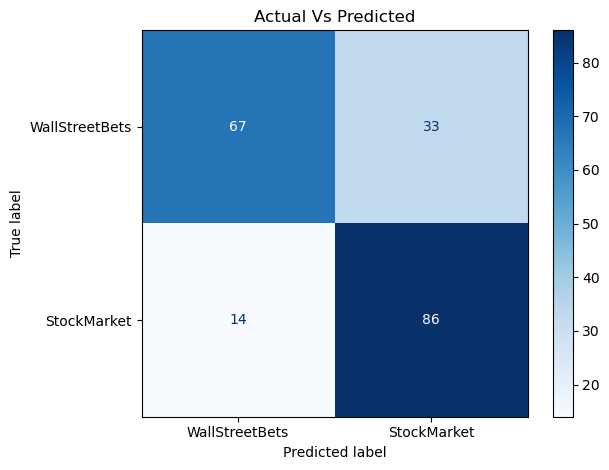

In [114]:
cm= confusion_matrix(test_y,preds,labels= rs_bag.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = ['WallStreetBets','StockMarket'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Actual Vs Predicted')
plt.tight_layout()
plt.savefig('./images/ConfusionMatrix')

In [129]:
print(classification_report(test_y,preds))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       100
           1       0.72      0.86      0.79       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200



From the confusion Matrix and classification report we can see that our model is having a harder time correctly classifying WallstreetBets. This could make a lot of sense because as shown earlier the text within WallstreetBets excluding a couple of phrases are pretty generic and was pretty common when looking at it with StockMarket.